<a href="https://colab.research.google.com/github/taras-musakovskyi/colab-jupyter-fish-models/blob/main/Custom_Resolution_Conditioned_Stable_Diffusion_1_5_LoRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!/usr/bin/env python3
"""
Stable Diffusion 1.5 LoRA Training for Unconditional Fish Generation (Point 1b)
Dataset: 12,301 fish images - uploaded as ZIP from local machine
Training: Google Colab with diffusers library
Models: Periodic upload to Google Drive
"""

# ============================================================================
# CELL 1: Environment Setup & Installation
# ============================================================================
!pip install -q diffusers transformers accelerate bitsandbytes safetensors xformers
!pip install -q torch torchvision --upgrade
!pip install -q peft huggingface_hub

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import json
import zipfile
import shutil
from pathlib import Path
from datetime import datetime
from tqdm.auto import tqdm
import numpy as np
from dataclasses import dataclass
from typing import Optional, List
import time

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 MB 21.7 MB/s eta 0:00:00
PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: NVIDIA A100-SXM4-80GB
VRAM: 79.32 GB


In [ ]:
# ============================================================================
# CELL 2: Google Drive Authentication (for uploading results only)
# ============================================================================
from google.colab import auth
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseUpload
import io

print("🔐 Authenticating with Google Drive for results upload...")

# Use Colab's built-in authentication
auth.authenticate_user()
from google.auth import default
creds, _ = default()

# Build Drive service
drive_service = build('drive', 'v3', credentials=creds)

print("✓ Authentication successful!")

# Set your results upload folder ID
# Get this by opening the target folder in Drive and copying the ID from URL
# Example: https://drive.google.com/drive/folders/1AbC123XyZ
GDRIVE_RESULTS_FOLDER_ID = "1PwD6uKkd735j2OL3J5A1aAyWNg0V4VZo" # custom res try 2
# Verify folder ID is set
if "YOUR_" in GDRIVE_RESULTS_FOLDER_ID or "_HERE" in GDRIVE_RESULTS_FOLDER_ID:
    print("\n⚠️  WARNING: Set GDRIVE_RESULTS_FOLDER_ID to upload results!")
    print("   1. Create a folder in Google Drive")
    print("   2. Copy the folder ID from the URL")
    print("   3. Update GDRIVE_RESULTS_FOLDER_ID above")
else:
    print(f"✓ Results will be uploaded to folder ID: {GDRIVE_RESULTS_FOLDER_ID}")

🔐 Authenticating with Google Drive for results upload...
✓ Authentication successful!
✓ Results will be uploaded to folder ID: 1PwD6uKkd735j2OL3J5A1aAyWNg0V4VZo


In [ ]:

# ============================================================================
# CELL 3: Upload and Extract Dataset from Local Machine
# ============================================================================
from google.colab import files

LOCAL_DATA_DIR = '/content/fish_dataset'

print("📤 Upload your dataset ZIP file from local machine")
print("   Expected file: FishCropsFromYolo.zip")
print("   This will open a file picker - select your ZIP file\n")

# Upload file from local machine
uploaded = files.upload()

# Get the uploaded filename
zip_filename = list(uploaded.keys())[0]
print(f"\n✓ Upload complete: {zip_filename}")
print(f"   Size: {len(uploaded[zip_filename]) / (1024**2):.2f} MB")

# Extract the ZIP file
print(f"\n📦 Extracting {zip_filename}...")
zip_path = f'/content/{zip_filename}'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/fish_dataset_temp')

print("✓ Extraction complete")

# Find the extracted folders and organize them
print("\n📁 Organizing dataset structure...")

extracted_root = '/content/fish_dataset_temp'
extracted_contents = os.listdir(extracted_root)

print(f"   Found: {extracted_contents}")

# Create organized structure
os.makedirs(LOCAL_DATA_DIR, exist_ok=True)

# Move folders to proper location
for item in extracted_contents:
    item_path = os.path.join(extracted_root, item)
    if os.path.isdir(item_path) and item.lower() in ['small', 'medium', 'wide']:
        dest_path = os.path.join(LOCAL_DATA_DIR, item.lower())
        if os.path.exists(dest_path):
            shutil.rmtree(dest_path)
        shutil.move(item_path, dest_path)
        print(f"   ✓ Moved {item} → {dest_path}")

# Count images in each folder
print(f"\n📊 Dataset Summary:")
total_images = 0
for size_cat in ['small', 'medium', 'wide']:
    folder_path = os.path.join(LOCAL_DATA_DIR, size_cat)
    if os.path.exists(folder_path):
        images = [f for f in os.listdir(folder_path)
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        count = len(images)
        total_images += count
        print(f"   {size_cat}: {count} images")
    else:
        print(f"   ⚠️  {size_cat}: folder not found")

print(f"\n✓ Total images loaded: {total_images}")
print(f"✓ Dataset ready at: {LOCAL_DATA_DIR}")

# Cleanup
shutil.rmtree(extracted_root)
os.remove(zip_path)
print("\n🧹 Cleaned up temporary files")

📤 Upload your dataset ZIP file from local machine
   Expected file: FishCropsFromYolo.zip
   This will open a file picker - select your ZIP file



Saving FishesNoPartialsLocal.zip to FishesNoPartialsLocal.zip

✓ Upload complete: FishesNoPartialsLocal.zip
   Size: 259.50 MB

📦 Extracting FishesNoPartialsLocal.zip...
✓ Extraction complete

📁 Organizing dataset structure...
   Found: ['__MACOSX', 'medium', 'wide', 'small']
   ✓ Moved medium → /content/fish_dataset/medium
   ✓ Moved wide → /content/fish_dataset/wide
   ✓ Moved small → /content/fish_dataset/small

📊 Dataset Summary:
   small: 1771 images
   medium: 4038 images
   wide: 3689 images

✓ Total images loaded: 9498
✓ Dataset ready at: /content/fish_dataset

🧹 Cleaned up temporary files


In [ ]:
# ============================================================================
# CELL 4: Configuration
# ============================================================================
@dataclass
class TrainingConfig:
    """Configuration for SD 1.5 LoRA training"""
    # Model settings
    pretrained_model_name: str = "runwayml/stable-diffusion-v1-5"
    resolution: int = 512  # SD 1.5 native resolution

    # LoRA settings
    lora_rank: int = 16  # Rank of LoRA matrices (4, 8, 16, 32)
    lora_alpha: int = 32  # Scaling factor (usually 2x rank)
    lora_dropout: float = 0.1

    # Training hyperparameters
    num_epochs: int = 55
    batch_size: int = 144
    gradient_accumulation_steps: int = 1
    learning_rate: float = 1e-4
    lr_scheduler: str = "cosine"
    warmup_steps: int = 800

    default_prompt: str = "a fish in aquarium"

    # Optimization
    use_8bit_adam: bool = True  # Saves VRAM
    mixed_precision: str = "fp16"  # "no", "fp16", "bf16"
    gradient_checkpointing: bool = True

    # Data augmentation (minimal for fish realism)
    center_crop: bool = True
    random_flip: bool = True

    # Logging & checkpointing
    save_every_n_epochs: int = 5
    validation_every_n_epochs: int = 5
    num_validation_images: int = 4

    resolution_width: int = 768  #
    resolution_height: int = 512  # (768/512 = 1.5 aspect ratio)

    # Periodic GDrive upload settings
    upload_after_epoch: int = 15  # Don't upload during first 25 epochs
    upload_interval_epochs: int = 3  # Upload every 5 epochs after threshold

    # Unconditional training (Point 1a)
    use_captions: bool = True  # Set True for Point 1b


    # Dataset paths
    dataset_root: str = LOCAL_DATA_DIR
    output_dir: str = "/content/sd_lora_outputs"

config = TrainingConfig()

# Create output directories
os.makedirs(config.output_dir, exist_ok=True)
os.makedirs(f"{config.output_dir}/checkpoints", exist_ok=True)
os.makedirs(f"{config.output_dir}/samples", exist_ok=True)

print("Configuration loaded:")
print(f"  Model: {config.pretrained_model_name}")
print(f"  LoRA rank: {config.lora_rank}, alpha: {config.lora_alpha}")
print(f"  Resolution: {config.resolution}x{config.resolution}")
print(f"  Batch size: {config.batch_size}, Gradient accum: {config.gradient_accumulation_steps}")
print(f"  Effective batch: {config.batch_size * config.gradient_accumulation_steps}")
print(f"  Learning rate: {config.learning_rate}")
print(f"  Epochs: {config.num_epochs}")
print(f"  Upload to GDrive: After epoch {config.upload_after_epoch}, every {config.upload_interval_epochs} epochs")


Configuration loaded:
  Model: runwayml/stable-diffusion-v1-5
  LoRA rank: 16, alpha: 32
  Resolution: 512x512
  Batch size: 144, Gradient accum: 1
  Effective batch: 144
  Learning rate: 0.0001
  Epochs: 55
  Upload to GDrive: After epoch 15, every 3 epochs


In [ ]:
# ============================================================================
# CELL 5: Dataset Class
# ============================================================================
class FishDataset(Dataset):
    """Dataset for fish images from small/medium/wide folders"""

    def __init__(self, root_dir: str, resolution_height: int = 512, resolution_width: int = 768,
             center_crop: bool = True, random_flip: bool = True,
             use_captions: bool = False, default_prompt: str = "a fish"):
      self.root_dir = Path(root_dir)
      self.resolution_height = resolution_height
      self.resolution_width = resolution_width
      self.use_captions = use_captions
      self.default_prompt = default_prompt

      # Collect all image paths from small/medium/wide folders
      self.image_paths = []
      for folder in ["small", "medium", "wide"]:
          folder_path = self.root_dir / folder
          if folder_path.exists():
              self.image_paths.extend(
                  list(folder_path.glob("*.jpg")) +
                  list(folder_path.glob("*.png"))
              )

      print(f"Found {len(self.image_paths)} images")

      # Build transforms
      transform_list = []

      if random_flip:
          transform_list.append(transforms.RandomHorizontalFlip(p=0.5))

      if center_crop:
          # Crop to target aspect ratio first (before resize)
          transform_list.append(transforms.CenterCrop((resolution_height, resolution_width)))

      transform_list.extend([
          transforms.Resize((resolution_height, resolution_width), interpolation=transforms.InterpolationMode.BILINEAR),
          transforms.ToTensor(),
          transforms.Normalize([0.5], [0.5])  # [-1, 1] range for SD
      ])

      self.transform = transforms.Compose(transform_list)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
      img_path = self.image_paths[idx]

      # Load and transform image
      image = Image.open(img_path).convert("RGB")
      pixel_values = self.transform(image)

      filename = img_path.name  # e.g., "gold_molly_20250926_102750_976_conf0.896.jpg"

      # Extract species (first part before first underscore+date pattern)
      # Split by underscore and take first part(s) until we hit a date (8 digits)
      parts = filename.split('_')

      # Species mapping - exact names from your dataset
      species_map = {
          "gold_fish": "goldfish",
          "ancistrus": "ancistrus catfish",
          "black_molly": "black molly fish",
          "dalmatian_molly": "dalmatian molly fish",
          "gold_molly": "gold molly fish",
          "guppy_female": "guppy fish",
          "guppy_male": "guppy fish",
      }

      # Extract species name (handles single and multi-part species)
      species_key = None
      if len(parts) >= 2:
          # Try two-part species first (gold_molly, guppy_female, etc)
          two_part = f"{parts[0]}_{parts[1]}"
          if two_part in species_map:
              species_key = two_part
          # Try single-part species (ancistrus)
          elif parts[0] in species_map:
              species_key = parts[0]

      if species_key:
          species_name = species_map[species_key]
          caption = f"a beautiful {species_name} swimming in aquarium"
      else:
          # Unknown species - log and use fallback
          print(f"⚠️ Unknown species in filename: {filename}")
          caption = "a fish in aquarium"


      return {
          "pixel_values": pixel_values,
          "input_ids": caption,
      }


In [ ]:
# ============================================================================
# CELL 6: Load Models & Setup LoRA
# ============================================================================
from diffusers import (
    StableDiffusionPipeline,
    UNet2DConditionModel,
    DDPMScheduler,
    AutoencoderKL
)
from transformers import CLIPTextModel, CLIPTokenizer
from peft import LoraConfig, get_peft_model
import bitsandbytes as bnb

print("Loading Stable Diffusion 1.5 models...")

tokenizer = CLIPTokenizer.from_pretrained(
    config.pretrained_model_name,
    subfolder="tokenizer"
)

text_encoder = CLIPTextModel.from_pretrained(
    config.pretrained_model_name,
    subfolder="text_encoder"
)

vae = AutoencoderKL.from_pretrained(
    config.pretrained_model_name,
    subfolder="vae"
)

unet = UNet2DConditionModel.from_pretrained(
    config.pretrained_model_name,
    subfolder="unet"
)

noise_scheduler = DDPMScheduler.from_pretrained(
    config.pretrained_model_name,
    subfolder="scheduler"
)

print("✓ Models loaded")

# Freeze VAE and text encoder (only train UNet with LoRA)
vae.requires_grad_(False)
text_encoder.requires_grad_(False)
unet.requires_grad_(False)

# Enable gradient checkpointing for memory efficiency
if config.gradient_checkpointing:
    unet.enable_gradient_checkpointing()

# Setup LoRA on UNet
lora_config = LoraConfig(
    r=config.lora_rank,
    lora_alpha=config.lora_alpha,
    init_lora_weights="gaussian",
    target_modules=["to_k", "to_q", "to_v", "to_out.0"],  # Attention layers
    lora_dropout=config.lora_dropout,
)

unet = get_peft_model(unet, lora_config)
unet.print_trainable_parameters()

# Move models to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae.to(device)

vae.enable_slicing()
vae.enable_tiling()

print("✓ VAE memory optimizations enabled")
text_encoder.to(device)
unet.to(device)

print(f"✓ Models moved to {device}")

Loading Stable Diffusion 1.5 models...
✓ Models loaded
trainable params: 3,188,736 || all params: 862,709,700 || trainable%: 0.3696
✓ VAE memory optimizations enabled
✓ Models moved to cuda


In [ ]:
# ============================================================================
# CELL 7: Setup Optimizer & Scheduler
# ============================================================================
from torch.optim import AdamW
from diffusers.optimization import get_scheduler

# Use 8-bit Adam if enabled (saves VRAM)
if config.use_8bit_adam:
    optimizer_class = bnb.optim.AdamW8bit
    print("Using 8-bit AdamW optimizer")
else:
    optimizer_class = AdamW
    print("Using standard AdamW optimizer")

optimizer = optimizer_class(
    unet.parameters(),
    lr=config.learning_rate,
    betas=(0.9, 0.999),
    weight_decay=1e-2,
    eps=1e-8,
)

train_dataset = FishDataset(
    root_dir=config.dataset_root,
    resolution_height=config.resolution_height,  # Changed
    resolution_width=config.resolution_width,     # Changed
    center_crop=config.center_crop,
    random_flip=config.random_flip,
    use_captions=config.use_captions,
    default_prompt=config.default_prompt,
)

num_training_steps = config.num_epochs * len(train_dataset) // (config.batch_size * config.gradient_accumulation_steps)

# Learning rate scheduler
lr_scheduler = get_scheduler(
    config.lr_scheduler,
    optimizer=optimizer,
    num_warmup_steps=config.warmup_steps,
    num_training_steps=num_training_steps,
)

print(f"✓ Optimizer and scheduler configured")
print(f"   Total training steps: {num_training_steps}")

Using 8-bit AdamW optimizer
Found 9498 images
✓ Optimizer and scheduler configured
   Total training steps: 3627


In [ ]:
# ============================================================================
# CELL 8: Create DataLoader
# ============================================================================
def collate_fn(examples):
    """Custom collate function to tokenize prompts"""
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    # Tokenize prompts
    prompts = [example["input_ids"] for example in examples]
    inputs = tokenizer(
        prompts,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    input_ids = inputs.input_ids

    return {
        "pixel_values": pixel_values,
        "input_ids": input_ids,
    }

train_dataloader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2,
    pin_memory=True,
)

print(f"✓ DataLoader created: {len(train_dataset)} images, {len(train_dataloader)} batches")

✓ DataLoader created: 9498 images, 66 batches


In [ ]:
# ============================================================================
# CELL 9: Training Loop with Periodic GDrive Upload
# ============================================================================
from accelerate import Accelerator

def upload_best_model_to_gdrive(epoch, best_model_dir, max_retries=3):
    """Upload best LoRA weights to Google Drive with retry logic"""
    for attempt in range(max_retries):
        try:
            print(f"\n📤 Uploading best model to Google Drive (attempt {attempt+1}/{max_retries})...")

            if not os.path.exists(best_model_dir):
                print("⚠️ Best model not found, skipping upload")
                return False

            # Check if it's a directory (PEFT format)
            if os.path.isdir(best_model_dir):
                # Find the actual model file inside
                adapter_file = os.path.join(best_model_dir, "adapter_model.safetensors")
                if not os.path.exists(adapter_file):
                    print(f"⚠️ adapter_model.safetensors not found in {best_model_dir}")
                    return False
                model_file_to_upload = adapter_file
            else:
                model_file_to_upload = best_model_dir

            # Load checkpoint info to get actual epoch number
            try:
                info_path = f"{config.output_dir}/checkpoints/lora_best_info.pth"
                if os.path.exists(info_path):
                    checkpoint = torch.load(info_path, map_location='cpu')
                    actual_epoch = checkpoint.get('epoch', epoch)
                else:
                    actual_epoch = epoch
            except:
                actual_epoch = epoch

            # Create timestamped filename
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            remote_filename = f'lora_1b_best_epoch_{actual_epoch}_{timestamp}.safetensors'

            file_metadata = {
                'name': remote_filename,
                'parents': [GDRIVE_RESULTS_FOLDER_ID]
            }

            # Upload the actual model file
            print(f"   Uploading: {os.path.basename(model_file_to_upload)}")
            with open(model_file_to_upload, 'rb') as f:
                media = MediaIoBaseUpload(
                    io.BytesIO(f.read()),
                    mimetype='application/octet-stream',
                    resumable=True
                )

            drive_service.files().create(
                body=file_metadata,
                media_body=media,
                fields='id'
            ).execute()

            print(f"✅ Best model uploaded: {remote_filename}")
            return True

        except Exception as e:
            print(f"⚠️ Upload attempt {attempt+1} failed: {e}")
            if attempt < max_retries - 1:
                wait_time = 2 ** attempt
                print(f"   Retrying in {wait_time} seconds...")
                time.sleep(wait_time)
            else:
                print(f"❌ Upload failed after {max_retries} attempts")
                return False

# Setup accelerator for mixed precision training
accelerator = Accelerator(
    gradient_accumulation_steps=config.gradient_accumulation_steps,
    mixed_precision=config.mixed_precision,
)

# Prepare for training
unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
    unet, optimizer, train_dataloader, lr_scheduler
)

# Training state
global_step = 0
best_loss = float('inf')
best_model_path = f"{config.output_dir}/checkpoints/lora_best.safetensors"
last_uploaded_epoch = 0

print("="*60)
print("STARTING TRAINING")
print("="*60)

for epoch in range(config.num_epochs):
    unet.train()
    epoch_loss = 0.0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{config.num_epochs}")

    for step, batch in enumerate(progress_bar):
        with accelerator.accumulate(unet):
            # Move batch to device
            pixel_values = batch["pixel_values"].to(device)
            input_ids = batch["input_ids"].to(device)

            # Encode images to latent space
            with torch.no_grad():
                latents = vae.encode(pixel_values).latent_dist.sample()
                latents = latents * vae.config.scaling_factor

            # Sample noise
            noise = torch.randn_like(latents)
            bsz = latents.shape[0]

            # Sample random timesteps
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps,
                (bsz,), device=device
            ).long()

            # Add noise to latents
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # Get text embeddings
            with torch.no_grad():
                encoder_hidden_states = text_encoder(input_ids)[0]

            # Predict noise
            model_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

            # Calculate loss (MSE between predicted and actual noise)
            loss = F.mse_loss(model_pred.float(), noise.float(), reduction="mean")

            # Backpropagation
            accelerator.backward(loss)

            if accelerator.sync_gradients:
                accelerator.clip_grad_norm_(unet.parameters(), 1.0)

            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        # Logging
        if accelerator.sync_gradients:
            global_step += 1
            epoch_loss += loss.detach().item()

            # Update progress bar
            progress_bar.set_postfix({
                "loss": f"{loss.detach().item():.4f}",
                "lr": f"{lr_scheduler.get_last_lr()[0]:.6f}"
            })

    # End of epoch
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    print(f"\nEpoch {epoch+1}/{config.num_epochs} - Average Loss: {avg_epoch_loss:.4f}")

    # Save best model
    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss
        unwrapped_unet = accelerator.unwrap_model(unet)
        unwrapped_unet.save_pretrained(
            best_model_path,
            safe_serialization=True
        )
        # Also save epoch info
        torch.save({
            'epoch': epoch + 1,
            'loss': avg_epoch_loss,
        }, f"{config.output_dir}/checkpoints/lora_best_info.pth")
        print(f"   🌟 New best model saved! Loss: {avg_epoch_loss:.4f}")

        # Upload to Google Drive if past threshold
        if (epoch + 1) >= config.upload_after_epoch and \
           (epoch + 1 - last_uploaded_epoch) >= config.upload_interval_epochs:
            if upload_best_model_to_gdrive(epoch + 1, best_model_path):
                last_uploaded_epoch = epoch + 1

    # Save checkpoint periodically
    if (epoch + 1) % config.save_every_n_epochs == 0:
        checkpoint_path = f"{config.output_dir}/checkpoints/lora_epoch_{epoch+1}.safetensors"
        accelerator.unwrap_model(unet).save_pretrained(
            checkpoint_path,
            safe_serialization=True
        )
        print(f"✓ Checkpoint saved: {checkpoint_path}")

    # Validation: Generate sample images
    if (epoch + 1) % config.validation_every_n_epochs == 0:
        unet.eval()
        with torch.no_grad():
            # Create pipeline for generation
            pipeline = StableDiffusionPipeline.from_pretrained(
                config.pretrained_model_name,
                unet=accelerator.unwrap_model(unet),
                text_encoder=text_encoder,
                vae=vae,
                tokenizer=tokenizer,
                torch_dtype=torch.float16,
            )
            pipeline = pipeline.to(device)

            # Point 1b: Species-specific validation prompts
            validation_prompts = [
                "a beautiful gold molly fish swimming in aquarium",
                "a beautiful female guppy fish swimming in aquarium",
                "a beautiful goldfish swimming in aquarium",
                "a beautiful ancistrus catfish swimming in aquarium",
            ]

            # Generate validation images
            images = pipeline(
                validation_prompts,
                num_inference_steps=30,
                guidance_scale=7.5,
            ).images

            # Save samples
            sample_dir = f"{config.output_dir}/samples/epoch_{epoch+1}"
            os.makedirs(sample_dir, exist_ok=True)
            for i, img in enumerate(images):
                img.save(f"{sample_dir}/sample_{i}.png")

            print(f"✓ Generated {len(images)} validation images")

            del pipeline  # Free memory
        unet.train()

    print("-" * 60)

print("="*60)
print("TRAINING COMPLETE!")
print(f"Best Loss: {best_loss:.4f}")
print("="*60)

# Final upload if not already uploaded
if last_uploaded_epoch < config.num_epochs:
    print("\n📤 Final upload of best model...")
    upload_best_model_to_gdrive(config.num_epochs, best_model_path)

# Save final model
final_model_path = f"{config.output_dir}/lora_final.safetensors"
accelerator.unwrap_model(unet).save_pretrained(
    final_model_path,
    safe_serialization=True
)
print(f"✓ Final model saved: {final_model_path}")


STARTING TRAINING


Epoch 1/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 1/55 - Average Loss: 0.0245
   🌟 New best model saved! Loss: 0.0245
------------------------------------------------------------


Epoch 2/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 2/55 - Average Loss: 0.0237
   🌟 New best model saved! Loss: 0.0237
------------------------------------------------------------


Epoch 3/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 3/55 - Average Loss: 0.0235
   🌟 New best model saved! Loss: 0.0235
------------------------------------------------------------


Epoch 4/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 4/55 - Average Loss: 0.0229
   🌟 New best model saved! Loss: 0.0229
------------------------------------------------------------


Epoch 5/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 5/55 - Average Loss: 0.0225
   🌟 New best model saved! Loss: 0.0225
✓ Checkpoint saved: /content/sd_lora_outputs/checkpoints/lora_epoch_5.safetensors


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
Expected types for unet: (<class 'diffusers.models.unets.unet_2d_condition.UNet2DConditionModel'>,), got <class 'peft.peft_model.PeftModel'>.


  0%|          | 0/30 [00:00<?, ?it/s]

✓ Generated 4 validation images
------------------------------------------------------------


Epoch 6/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 6/55 - Average Loss: 0.0228
------------------------------------------------------------


Epoch 7/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 7/55 - Average Loss: 0.0227
------------------------------------------------------------


Epoch 8/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 8/55 - Average Loss: 0.0225
   🌟 New best model saved! Loss: 0.0225
------------------------------------------------------------


Epoch 9/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 9/55 - Average Loss: 0.0222
   🌟 New best model saved! Loss: 0.0222
------------------------------------------------------------


Epoch 10/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 10/55 - Average Loss: 0.0224
✓ Checkpoint saved: /content/sd_lora_outputs/checkpoints/lora_epoch_10.safetensors


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Expected types for unet: (<class 'diffusers.models.unets.unet_2d_condition.UNet2DConditionModel'>,), got <class 'peft.peft_model.PeftModel'>.


  0%|          | 0/30 [00:00<?, ?it/s]

✓ Generated 4 validation images
------------------------------------------------------------


Epoch 11/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 11/55 - Average Loss: 0.0221
   🌟 New best model saved! Loss: 0.0221
------------------------------------------------------------


Epoch 12/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 12/55 - Average Loss: 0.0222
------------------------------------------------------------


Epoch 13/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 13/55 - Average Loss: 0.0221
------------------------------------------------------------


Epoch 14/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 14/55 - Average Loss: 0.0216
   🌟 New best model saved! Loss: 0.0216
------------------------------------------------------------


Epoch 15/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 15/55 - Average Loss: 0.0221
✓ Checkpoint saved: /content/sd_lora_outputs/checkpoints/lora_epoch_15.safetensors


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Expected types for unet: (<class 'diffusers.models.unets.unet_2d_condition.UNet2DConditionModel'>,), got <class 'peft.peft_model.PeftModel'>.


  0%|          | 0/30 [00:00<?, ?it/s]

✓ Generated 4 validation images
------------------------------------------------------------


Epoch 16/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 16/55 - Average Loss: 0.0219
------------------------------------------------------------


Epoch 17/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 17/55 - Average Loss: 0.0220
------------------------------------------------------------


Epoch 18/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 18/55 - Average Loss: 0.0220
------------------------------------------------------------


Epoch 19/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 19/55 - Average Loss: 0.0227
------------------------------------------------------------


Epoch 20/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 20/55 - Average Loss: 0.0223
✓ Checkpoint saved: /content/sd_lora_outputs/checkpoints/lora_epoch_20.safetensors


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Expected types for unet: (<class 'diffusers.models.unets.unet_2d_condition.UNet2DConditionModel'>,), got <class 'peft.peft_model.PeftModel'>.


  0%|          | 0/30 [00:00<?, ?it/s]

✓ Generated 4 validation images
------------------------------------------------------------


Epoch 21/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 21/55 - Average Loss: 0.0226
------------------------------------------------------------


Epoch 22/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 22/55 - Average Loss: 0.0219
------------------------------------------------------------


Epoch 23/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 23/55 - Average Loss: 0.0230
------------------------------------------------------------


Epoch 24/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 24/55 - Average Loss: 0.0214
   🌟 New best model saved! Loss: 0.0214

📤 Uploading best model to Google Drive (attempt 1/3)...
   Uploading: adapter_model.safetensors
✅ Best model uploaded: lora_1b_best_epoch_24_20251005_225313.safetensors
------------------------------------------------------------


Epoch 25/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 25/55 - Average Loss: 0.0213
   🌟 New best model saved! Loss: 0.0213
✓ Checkpoint saved: /content/sd_lora_outputs/checkpoints/lora_epoch_25.safetensors


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Expected types for unet: (<class 'diffusers.models.unets.unet_2d_condition.UNet2DConditionModel'>,), got <class 'peft.peft_model.PeftModel'>.


  0%|          | 0/30 [00:00<?, ?it/s]

✓ Generated 4 validation images
------------------------------------------------------------


Epoch 26/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 26/55 - Average Loss: 0.0217
------------------------------------------------------------


Epoch 27/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 27/55 - Average Loss: 0.0215
------------------------------------------------------------


Epoch 28/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 28/55 - Average Loss: 0.0220
------------------------------------------------------------


Epoch 29/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 29/55 - Average Loss: 0.0220
------------------------------------------------------------


Epoch 30/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 30/55 - Average Loss: 0.0221
✓ Checkpoint saved: /content/sd_lora_outputs/checkpoints/lora_epoch_30.safetensors


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Expected types for unet: (<class 'diffusers.models.unets.unet_2d_condition.UNet2DConditionModel'>,), got <class 'peft.peft_model.PeftModel'>.


  0%|          | 0/30 [00:00<?, ?it/s]

✓ Generated 4 validation images
------------------------------------------------------------


Epoch 31/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 31/55 - Average Loss: 0.0224
------------------------------------------------------------


Epoch 32/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 32/55 - Average Loss: 0.0218
------------------------------------------------------------


Epoch 33/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 33/55 - Average Loss: 0.0221
------------------------------------------------------------


Epoch 34/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 34/55 - Average Loss: 0.0224
------------------------------------------------------------


Epoch 35/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 35/55 - Average Loss: 0.0213
✓ Checkpoint saved: /content/sd_lora_outputs/checkpoints/lora_epoch_35.safetensors


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Expected types for unet: (<class 'diffusers.models.unets.unet_2d_condition.UNet2DConditionModel'>,), got <class 'peft.peft_model.PeftModel'>.


  0%|          | 0/30 [00:00<?, ?it/s]

✓ Generated 4 validation images
------------------------------------------------------------


Epoch 36/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 36/55 - Average Loss: 0.0219
------------------------------------------------------------


Epoch 37/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 37/55 - Average Loss: 0.0217
------------------------------------------------------------


Epoch 38/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 38/55 - Average Loss: 0.0219
------------------------------------------------------------


Epoch 39/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 39/55 - Average Loss: 0.0216
------------------------------------------------------------


Epoch 40/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 40/55 - Average Loss: 0.0218
✓ Checkpoint saved: /content/sd_lora_outputs/checkpoints/lora_epoch_40.safetensors


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Expected types for unet: (<class 'diffusers.models.unets.unet_2d_condition.UNet2DConditionModel'>,), got <class 'peft.peft_model.PeftModel'>.


  0%|          | 0/30 [00:00<?, ?it/s]

✓ Generated 4 validation images
------------------------------------------------------------


Epoch 41/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 41/55 - Average Loss: 0.0224
------------------------------------------------------------


Epoch 42/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 42/55 - Average Loss: 0.0222
------------------------------------------------------------


Epoch 43/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 43/55 - Average Loss: 0.0223
------------------------------------------------------------


Epoch 44/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 44/55 - Average Loss: 0.0219
------------------------------------------------------------


Epoch 45/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 45/55 - Average Loss: 0.0211
   🌟 New best model saved! Loss: 0.0211

📤 Uploading best model to Google Drive (attempt 1/3)...
   Uploading: adapter_model.safetensors
✅ Best model uploaded: lora_1b_best_epoch_45_20251006_050401.safetensors
✓ Checkpoint saved: /content/sd_lora_outputs/checkpoints/lora_epoch_45.safetensors


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Expected types for unet: (<class 'diffusers.models.unets.unet_2d_condition.UNet2DConditionModel'>,), got <class 'peft.peft_model.PeftModel'>.


  0%|          | 0/30 [00:00<?, ?it/s]

✓ Generated 4 validation images
------------------------------------------------------------


Epoch 46/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 46/55 - Average Loss: 0.0217
------------------------------------------------------------


Epoch 47/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 47/55 - Average Loss: 0.0224
------------------------------------------------------------


Epoch 48/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 48/55 - Average Loss: 0.0217
------------------------------------------------------------


Epoch 49/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 49/55 - Average Loss: 0.0220
------------------------------------------------------------


Epoch 50/55:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch 50/55 - Average Loss: 0.0221
✓ Checkpoint saved: /content/sd_lora_outputs/checkpoints/lora_epoch_50.safetensors


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Expected types for unet: (<class 'diffusers.models.unets.unet_2d_condition.UNet2DConditionModel'>,), got <class 'peft.peft_model.PeftModel'>.


  0%|          | 0/30 [00:00<?, ?it/s]

✓ Generated 4 validation images
------------------------------------------------------------


Epoch 51/55:   0%|          | 0/66 [00:00<?, ?it/s]

KeyboardInterrupt: 


RUNNING INFERENCE


Keyword arguments {'dtype': torch.float16} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading LoRA weights from: /content/sd_lora_outputs/checkpoints/lora_best.safetensors
✓ Inference pipeline ready with LoRA

Generating 5 species-specific images...


  0%|          | 0/30 [00:00<?, ?it/s]

✓ Saved: /content/sd_lora_outputs/generated_images/generated_0_a_beautiful_gold_molly_fish_sw.png


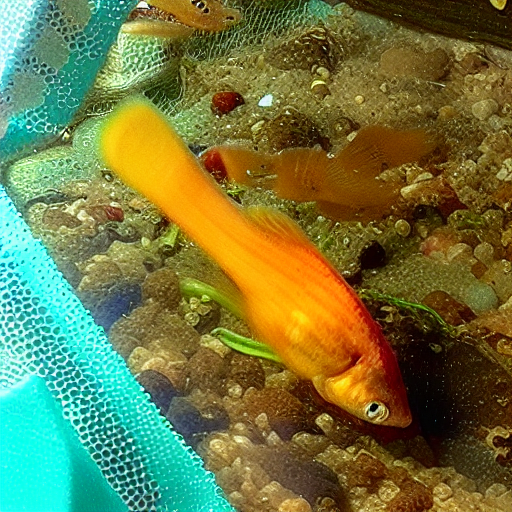

✓ Saved: /content/sd_lora_outputs/generated_images/generated_1_a_female_guppy_fish_with_color.png


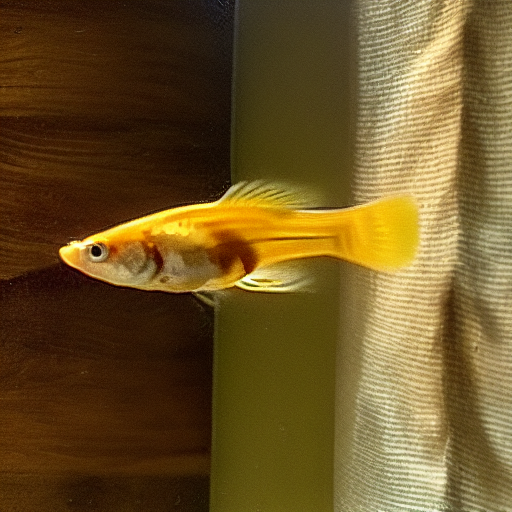

✓ Saved: /content/sd_lora_outputs/generated_images/generated_2_a_goldfish_in_clear_water.png


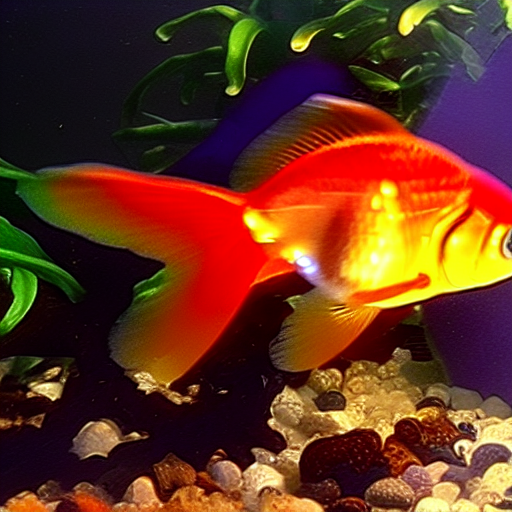

✓ Saved: /content/sd_lora_outputs/generated_images/generated_3_an_ancistrus_catfish_on_substr.png


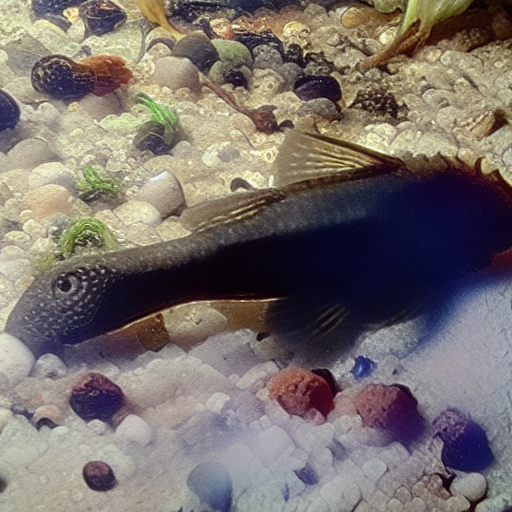

✓ Saved: /content/sd_lora_outputs/generated_images/generated_4_a_black_molly_fish.png


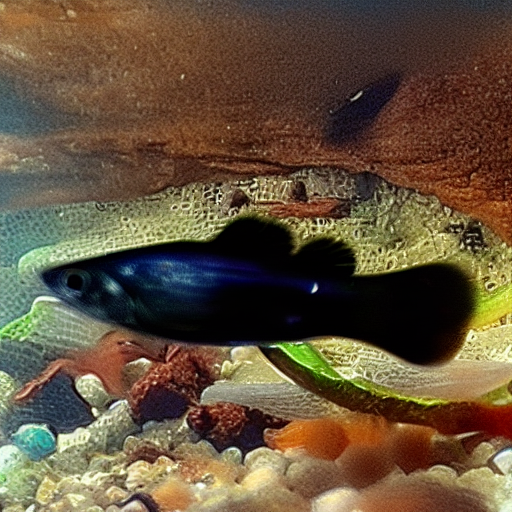


✓ All images saved to: /content/sd_lora_outputs/generated_images
POINT 1A COMPLETE: UNCONDITIONAL FISH GENERATION


In [ ]:
# ============================================================================
# CELL 10: Inference - Generate Fish Images (FIXED)
# ============================================================================
print("\n" + "="*60)
print("RUNNING INFERENCE")
print("="*60)

from diffusers import DPMSolverMultistepScheduler
from peft import PeftModel

# Create base pipeline
inference_pipeline = StableDiffusionPipeline.from_pretrained(
    config.pretrained_model_name,
    dtype=torch.float16,
)
inference_pipeline.scheduler = DPMSolverMultistepScheduler.from_config(
    inference_pipeline.scheduler.config
)

# Load LoRA weights using PEFT
print(f"Loading LoRA weights from: {best_model_path}")
inference_pipeline.unet = PeftModel.from_pretrained(
    inference_pipeline.unet,
    best_model_path,
    adapter_name="fish_lora"
)

inference_pipeline = inference_pipeline.to(device)
print("✓ Inference pipeline ready with LoRA")

prompts = [
    "a beautiful gold molly fish swimming in aquarium",
    "a female guppy fish with colorful fins",
    "a goldfish in clear water",
    "an ancistrus catfish on substrate",
    "a black molly fish",
]

print(f"\nGenerating {len(prompts)} species-specific images...")

# Optional: reduce metallic look
negative_prompts = ["metallic, shiny, reflective, mirror-like"] * len(prompts)


generated_images = inference_pipeline(
    prompts,
    negative_prompt=negative_prompts,
    num_inference_steps=30,
    guidance_scale=6.5,  # Reduced from 7.5 to soften metallic look
    num_images_per_prompt=1,
).images

# Save generated images
inference_output_dir = f"{config.output_dir}/generated_images"
os.makedirs(inference_output_dir, exist_ok=True)

for i, (img, prompt) in enumerate(zip(generated_images, prompts)):
    save_path = f"{inference_output_dir}/generated_{i}_{prompt.replace(' ', '_')[:30]}.png"
    img.save(save_path)
    print(f"✓ Saved: {save_path}")
    # Display in notebook
    display(img)

print(f"\n✓ All images saved to: {inference_output_dir}")
print("="*60)
print("POINT 1A COMPLETE: UNCONDITIONAL FISH GENERATION")
print("="*60)

In [ ]:
# ============================================================================
# CELL 11 (FIXED): Find and Upload Best Model
# ============================================================================

import os
import io
from googleapiclient.http import MediaIoBaseUpload
from datetime import datetime
import time

# Check what's actually in the checkpoints folder
checkpoint_dir = f"{config.output_dir}/checkpoints/lora_best.safetensors"

print("="*60)
print("FINDING BEST MODEL FILES")
print("="*60)

# List contents of the "directory"
if os.path.isdir(checkpoint_dir):
    print(f"\n✓ lora_best.safetensors is a directory. Contents:")
    for item in os.listdir(checkpoint_dir):
        item_path = os.path.join(checkpoint_dir, item)
        size = os.path.getsize(item_path) / (1024**2)
        print(f"   - {item} ({size:.2f} MB)")

    # Find the actual model file (usually adapter_model.safetensors)
    model_file = None
    for item in os.listdir(checkpoint_dir):
        if item.endswith('.safetensors') or item.endswith('.bin'):
            model_file = os.path.join(checkpoint_dir, item)
            break

    if not model_file:
        print("\n❌ No .safetensors or .bin file found in directory")
        print("Available files:")
        for item in os.listdir(checkpoint_dir):
            print(f"   - {item}")
else:
    model_file = checkpoint_dir
    print(f"\n✓ Found model file: {model_file}")

if model_file and os.path.exists(model_file):
    print(f"\n✓ Model file to upload: {model_file}")
    print(f"   Size: {os.path.getsize(model_file) / (1024**2):.2f} MB")

    # Upload function
    def upload_model_to_gdrive(model_path, max_retries=3):
        for attempt in range(max_retries):
            try:
                print(f"\n📤 Uploading model (attempt {attempt+1}/{max_retries})...")

                timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
                filename = os.path.basename(model_path)
                remote_filename = f'lora_best_epoch_24_{timestamp}_{filename}'

                file_metadata = {
                    'name': remote_filename,
                    'parents': [GDRIVE_RESULTS_FOLDER_ID]
                }

                with open(model_path, 'rb') as f:
                    file_data = f.read()

                print(f"   Size: {len(file_data) / (1024**2):.2f} MB")

                media = MediaIoBaseUpload(
                    io.BytesIO(file_data),
                    mimetype='application/octet-stream',
                    resumable=True
                )

                uploaded_file = drive_service.files().create(
                    body=file_metadata,
                    media_body=media,
                    fields='id,name,webViewLink'
                ).execute()

                print(f"\n✅ Upload successful!")
                print(f"   Filename: {remote_filename}")
                print(f"   File ID: {uploaded_file.get('id')}")

                return True

            except Exception as e:
                print(f"⚠️ Attempt {attempt+1} failed: {e}")
                if attempt < max_retries - 1:
                    time.sleep(2 ** attempt)
                else:
                    return False
        return False

    # Upload
    upload_model_to_gdrive(model_file)

else:
    print("\n❌ Could not find model file to upload")

print("="*60)

FINDING BEST MODEL FILES

✓ lora_best.safetensors is a directory. Contents:
   - adapter_model.safetensors (12.20 MB)
   - README.md (0.00 MB)
   - adapter_config.json (0.00 MB)

✓ Model file to upload: /content/sd_lora_outputs/checkpoints/lora_best.safetensors/adapter_model.safetensors
   Size: 12.20 MB

📤 Uploading model (attempt 1/3)...
   Size: 12.20 MB

✅ Upload successful!
   Filename: lora_best_epoch_24_20251006_063613_adapter_model.safetensors
   File ID: 1I2ZZaMYF9djFGF_0ffYjQGqdJLXCN9Qy
